In [2]:
#! pip install eventdetector_ts
! pip install pyod


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.1-py3-none-any.whl size=193269 sha256=d9020075d6f0edce2a7fcf54efee7852d1b8d1b2eacde4c464b14e594bec702c
  Stored in directory: /root/.cache/pip/wheels/94/75/88/b853cf33b0053b0a001dca55b74d515048b7656e736364eb57
Successfully built pyod


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

import numpy as np

In [ ]:
#DO NOT USE - Legacy code
'''
def extractKeyEventTimestamps(temporary_df):
  event_timestamp_list = temporary_df.loc[temporary_df['keyEventFlag']!=0, 'Timestamp']
  temporary_df = temporary_df.drop(columns=['keyEventFlag'])
  return temporary_df, event_timestamp_list
'''

In [6]:
def extractKeyEvents(temporary_df):
  event_flag_df = temporary_df['keyEventFlag']
  temporary_df = temporary_df.drop(columns=['keyEventFlag'])
  return temporary_df, event_flag_df

In [7]:
def flattenData(data, labels):
  x = []
  y = []
  data_df = data[0]
  labels_df = labels[0]

  try:
    for i in range(1,len(data)-1):
      data_df = pd.concat([data_df, data[i]], ignore_index=True)
      labels_df = pd.concat([labels_df, labels[i]], ignore_index=True)
    return data_df,labels_df
  except Exception as e:
    print(str(e))

In [ ]:
#DO NOT RUN - Legacy code
'''
s_eye = 'eye'

shared_folder = '/content/drive/MyDrive/Colab Notebooks/dissertationDataSet/processedData/'
if not os.path.exists(shared_folder):
  print(shared_folder +' does not exist.')

#Create the data_df and the event_df:
data_df_headers = ['Sensor_Data']
event_df_headers= ['Event_Timestamp_Data']

data_df=pd.DataFrame(columns=data_df_headers)
event_df = pd.DataFrame(columns=event_df_headers)

#create a list of file_names to be uploaded
file_names = os.listdir(shared_folder)
for file in file_names:
  [data_type, subject] = file.split('_')

  if s_eye == data_type:

    temporary_df = pd.read_csv(os.path.join(shared_folder, file), usecols=[1,2,3,4])

    temporary_df,event_timestamp_list = extractKeyEventTimestamps(temporary_df)


    data_df_row = {'Sensor_Data':temporary_df}
    event_df_row = {'Event_Timestamp_Data': event_timestamp_list}
    data_df=data_df.append(data_df_row, ignore_index=True)
    event_df=event_df.append(event_df_row, ignore_index=True)
'''

In [8]:
s_eye = 'eye'

shared_folder = '/content/drive/MyDrive/Colab Notebooks/dissertationDataSet/processedData/'
if not os.path.exists(shared_folder):
  print(shared_folder +' does not exist.')

X=[]
y=[]

#create a list of file_names to be uploaded
file_names = os.listdir(shared_folder)
for file in file_names:
  [data_type, subject] = file.split('_')

  if s_eye == data_type:

    temporary_df = pd.read_csv(os.path.join(shared_folder, file), usecols=[1,2,3,4])

    temporary_df,event_flag_df = extractKeyEvents(temporary_df)

    X.append(temporary_df)
    y.append(event_flag_df)

In [ ]:
#DO NOT RUN - Test the data_df and event_df
'''
toPrint = data_df['Sensor_Data'].iloc[1]['Pupil_diameter_L'].iat[48966]


toPrintevent = event_df['Event_Timestamp_Data'].iloc[0].iat[0]
print(toPrintevent)
'''

1970-01-01 00:09:20.000160


In [ ]:
#DO NOT RUN - test block
'''
datapoints = 0
print (len(X))
for i in range(len(X)):
  k=X[i]
  datapoints+=len(k)
  k.plot(x="Timestamp")

print(datapoints)

plt.plot(np.array(X_train)[:,0])
'''

59
3115313


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

In [ ]:
#DO NOT RUN - block of code to test dataset split
'''
print(type(X_train))
print(type(X_train[0]))
print(len(X_train))
print("----")
print(type(y_train))
print(type(y_train[0]))
print(len(y_train))
'''

<class 'list'>
<class 'pandas.core.frame.DataFrame'>
41
----
<class 'list'>
<class 'pandas.core.series.Series'>
41


In [10]:
X_train_flat, y_train_flat = flattenData(X_train, y_train)
X_test_flat, y_test_flat = flattenData(X_test, y_test)

In [ ]:
#DO NOT RUN - code block to test flattenData yields correct results
'''
print(len(X_train))
print(X_train_flat.shape)
print("---")
print(len(y_train))
print(y_train_flat.shape)
'''

41
(2091237, 3)
---
41
(2091237,)


In [ ]:
#DO NOT RUN - Legacy block
'''
def removeInvalidMeasurements_old(values,flags):
    x_np = np.array(values)
    y_np = np.array(flags)

    new_x = np.full((1,3),None)
    new_y = []

    first_time = True

    for ind in range(x_np.shape[0]):
      value = x_np[ind]
      if (value[1]>0 and value[2]>0 and first_time==True):
        new_y.append(y_np[ind])
        new_x[0]= x_np[ind]
        first_time=False
        continue;
      elif(value[1]>0 and value[2]>0):
        new_y.append(y_np[ind])
        new_x = np.vstack((new_x,x_np[ind]))

    return new_x, new_y
'''

In [11]:
def removeInvalidMeasurements(values,flags):
    x_np = np.array(values)
    y_np = np.array(flags)

    valid_mask_1 = (x_np[:,1]>0)

    nx_np = x_np[valid_mask_1]
    ny_np = y_np[valid_mask_1]

    valid_mask_2 = (nx_np[:,2]>0)

    new_x = nx_np[valid_mask_2]
    new_y = ny_np[valid_mask_2]

    return new_x, new_y

In [12]:
#Remove invalid measurements
new_x_train, new_y_train = removeInvalidMeasurements(X_train_flat, y_train_flat)

new_x_test, new_y_test = removeInvalidMeasurements(X_test_flat, y_test_flat)

1992368


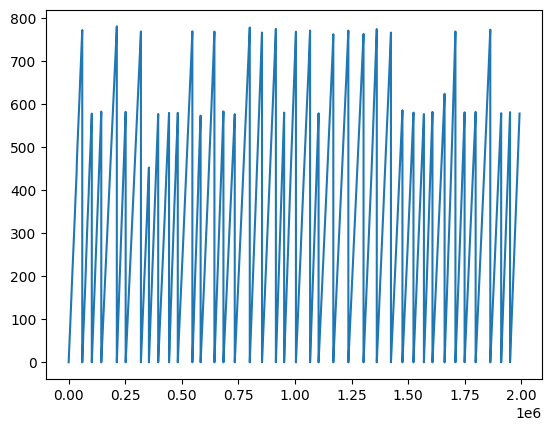

In [ ]:
#DO NOT RUN - test block
'''
print(len(new_x_train))
plt.plot(new_x_train[:,0])

plt.plot(np.array(X_train_flat)[:,0])
#TODO investigaste and fix data - Done
'''

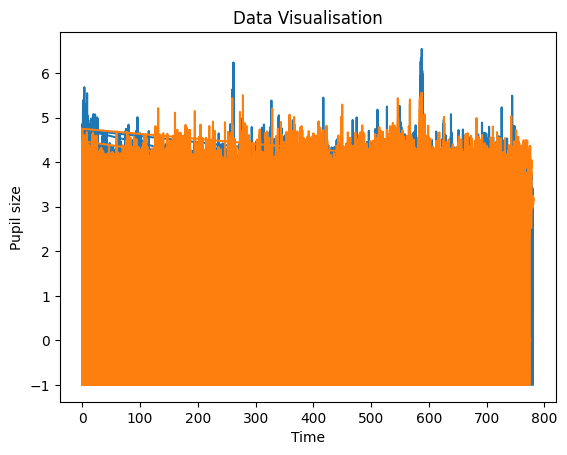

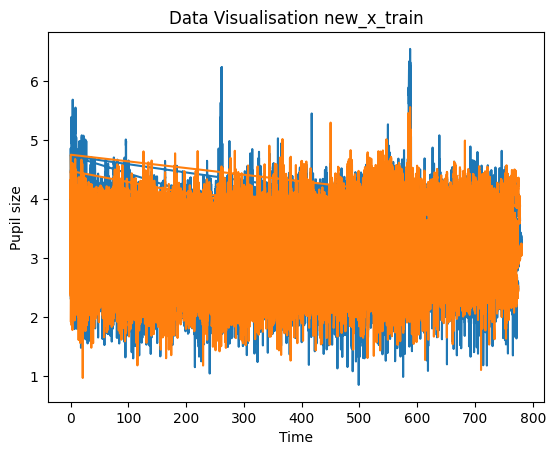

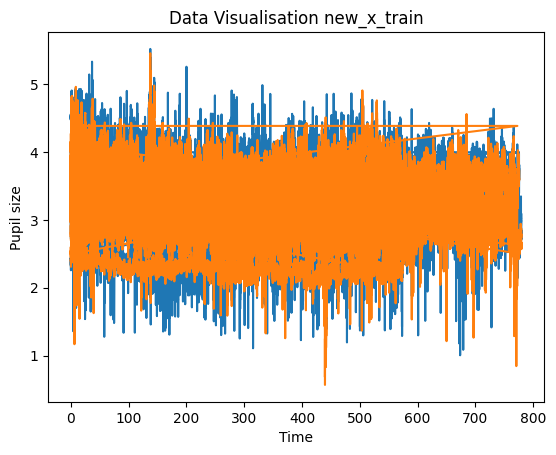

In [ ]:
#DO NOT RUN - Plot data for visualization
'''
plt.plot(np.array(X_train_flat)[:,0],np.array(X_train_flat)[:,1:])
plt.title("Data Visualisation")
plt.xlabel("Time")
plt.ylabel("Pupil size")
plt.show()

plt.plot(new_x_train[:,0],new_x_train[:,1:])
plt.title("Data Visualisation new_x_train")
plt.xlabel("Time")
plt.ylabel("Pupil size")
plt.show()

plt.plot(new_x_test[:,0],new_x_test[:,1:])
plt.title("Data Visualisation new_x_train")
plt.xlabel("Time")
plt.ylabel("Pupil size")
plt.show()
'''

In [ ]:
x_test_rows = X_test_flat.isna().any(axis=1)
indexes_nan = x_test_rows[x_test_rows].index.tolist()

if not x_test_rows.empty:
  X_test_flat.drop(index= indexes_nan, inplace=True)
  y_test_flat.drop(index =indexes_nan, inplace=True)

In [ ]:
#Do not run - This is to optimise KNN performance by running a grid search to provide best parameters
'''
param_grid = {
    'n_neighbors':[1,5,20],
    'method':['largest', 'mean', 'median'],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

knn = KNN()

grid_search =  GridSearchCV(estimator=knn, param_grid=param_grid, scoring='accuracy', cv=3)

# Run the grid search
grid_search.fit(new_x_train, new_y_train)

# Get the best parameters and the best model
print("Best parameters:", grid_search.best_params_)
'''

/usr/local/lib/python3.10/dist-packages/pyod/models/base.py:425: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyod/models/base.py:425: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyod/models/base.py:425: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyod/models/base.py:425: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyod/models/base.py:425: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyod/models/base.py:425: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyod/models/base.py:425: UserWarning: y should not be presented in unsupervise

Best parameters: {'method': 'largest', 'metric': 'euclidean', 'n_neighbors': 20}


In [11]:
clf_name = 'KNN'
contamination = 0.1361
model = KNN(n_neighbors=3, method = 'mean', metric = 'euclidean')
model.fit(new_x_train)

y_train_pred = model.predict(new_x_train)
y_train_scores = model.decision_function(new_x_train)

y_test_pred=model.predict(new_x_test)
y_test_scores = model.decision_function(new_x_test)

y_test_pred,y_test_pred_confidence = model.predict(new_x_test,return_confidence = True)

plt.hist(y_train_scores,bins=50,density=True, alpha=0.75,color='blue')
plt.xlabel('Outlier score')
plt.ylabel('Density')
plt.title('Histogram of outlier scores for training data')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [ ]:
print("\nOn Training Data:")
print(classification_report(new_y_train, y_train_pred))

print("\nOn Test Data:")
print(classification_report(new_y_test, y_test_pred))


On Training Data:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99   1984527
         1.0       0.00      0.03      0.01      7841

    accuracy                           0.97   1992368
   macro avg       0.50      0.50      0.50   1992368
weighted avg       0.99      0.97      0.98   1992368


On Test Data:
              precision    recall  f1-score   support

         0.0       1.00      0.28      0.44    877513
         1.0       0.00      0.72      0.01      3371

    accuracy                           0.28    880884
   macro avg       0.50      0.50      0.22    880884
weighted avg       0.99      0.28      0.44    880884



In [ ]:
#Isolation Forest

# Initialize Isolation Forest
clf = IForest(n_estimators=100, max_samples='auto', contamination=0.01, random_state=42)

# Fit the model
clf.fit(new_x_train)

# Predictions
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

y_test_pred = clf.predict(new_x_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(new_x_test)  # outlier scores

# Evaluation
print("\nOn Training Data:")
print(classification_report(new_y_train, y_train_pred))

print("\nOn Test Data:")
print(classification_report(new_y_test, y_test_pred))


On Training Data:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99   1984527
         1.0       0.00      0.01      0.01      7841

    accuracy                           0.99   1992368
   macro avg       0.50      0.50      0.50   1992368
weighted avg       0.99      0.99      0.99   1992368


On Test Data:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    877513
         1.0       0.00      0.02      0.01      3371

    accuracy                           0.97    880884
   macro avg       0.50      0.50      0.50    880884
weighted avg       0.99      0.97      0.98    880884



In [13]:
#DO NOT USE - Alternative approach with averaged results replacing L&R pupil series
#This block creates a new series (replacing new_x_train & test) with an
#array of timestamps and the average of the pupils
'''
average_train= new_x_train[:,0].reshape(-1,1)
average_test= new_x_test[:,0].reshape(-1,1)

combined_pupil_train = (new_x_train[:,1]+new_x_train[:,2])/2
combined_pupil_test = (new_x_test[:,1]+new_x_test[:,2])/2

combined_pupil_train_reshaped = combined_pupil_train.reshape(-1, 1)
combined_pupil_test_reshaped = combined_pupil_test.reshape(-1, 1)

average_pupil_train = np.hstack((average_train,combined_pupil_train_reshaped))
average_pupil_test = np.hstack((average_test,combined_pupil_test_reshaped))
'''

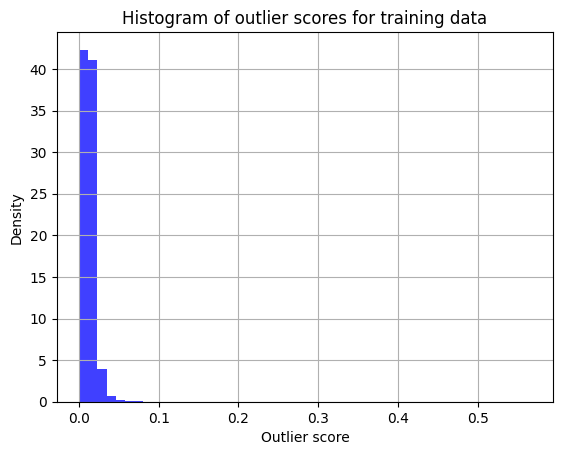


On Training Data:
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98   1984527
         1.0       0.00      0.03      0.01      7841

    accuracy                           0.96   1992368
   macro avg       0.50      0.50      0.49   1992368
weighted avg       0.99      0.96      0.98   1992368


On Test Data:
              precision    recall  f1-score   support

         0.0       1.00      0.57      0.73    877513
         1.0       0.00      0.42      0.01      3371

    accuracy                           0.57    880884
   macro avg       0.50      0.49      0.37    880884
weighted avg       0.99      0.57      0.73    880884



In [13]:
#TEST CODE, DO NOT RUN - Alternative KNN with datasets created above
'''
clf_name = 'KNN'
contamination = 0.1361
model = KNN(n_neighbors=5, method = 'mean', metric = 'euclidean')
model.fit(average_pupil_train)

y_train_pred = model.predict(average_pupil_train)
y_train_scores = model.decision_function(average_pupil_train)

y_test_pred=model.predict(average_pupil_test)
y_test_scores = model.decision_function(average_pupil_test)

y_test_pred,y_test_pred_confidence = model.predict(average_pupil_test,return_confidence = True)

plt.hist(y_train_scores,bins=50,density=True, alpha=0.75,color='blue')
plt.xlabel('Outlier score')
plt.ylabel('Density')
plt.title('Histogram of outlier scores for training data')
plt.grid(True)
plt.show()

print("\nOn Training Data:")
print(classification_report(new_y_train, y_train_pred))

print("\nOn Test Data:")
print(classification_report(new_y_test, y_test_pred))
'''

<class 'numpy.ndarray'>


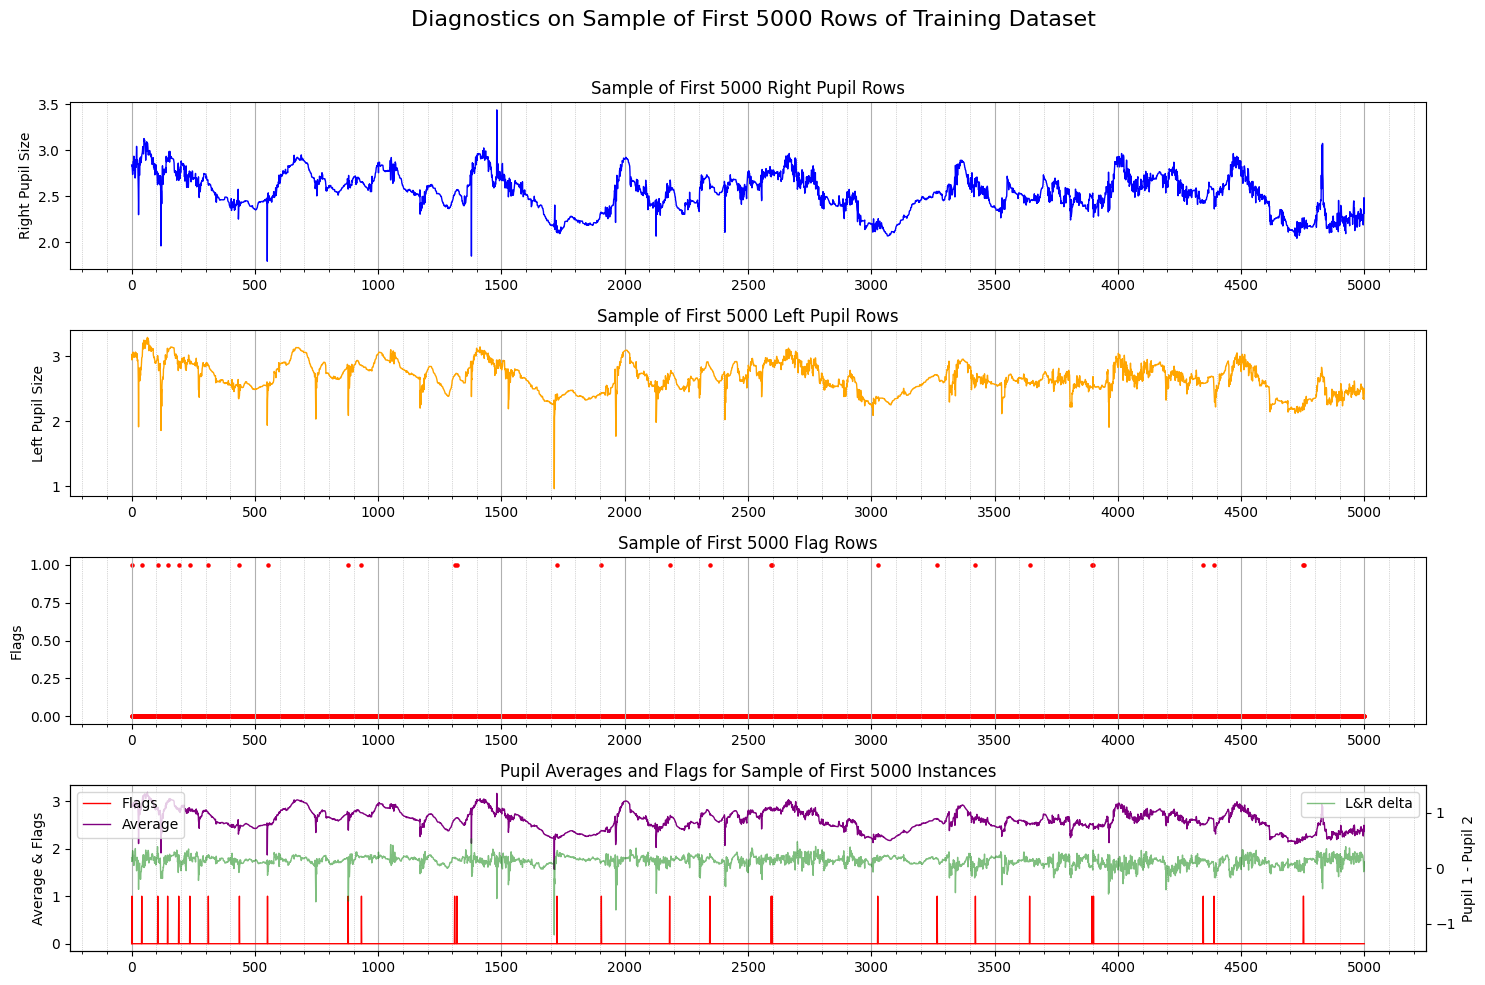

In [47]:
#DO not run - Code for visualisiation for report
'''
from matplotlib.ticker import MultipleLocator

print(type(average_pupil_train))
sample_data=average_pupil_train[:5000,1]
sample_flag=new_y_train[:5000]
new_x_sample_R = new_x_train[:5000,1]
new_x_sample_L = new_x_train[:5000,2]

x = np.arange(0, 5000,1)
y1 = sample_data
y2 = sample_flag
y3 = new_x_sample_R
y4 = new_x_sample_L
y5 = new_x_sample_L-new_x_sample_R

# Plotting
plt.figure(figsize=(15, 10))  # Adjusted figure size for better readability

plt.subplot(4, 1, 1)
plt.plot(x, y3, label='R', color='blue', linewidth=1)
plt.title('Sample of First 5000 Right Pupil Rows')
plt.grid(axis='x')
plt.ylabel('Right Pupil Size')
plt.gca().xaxis.set_major_locator(MultipleLocator(500))
plt.gca().xaxis.set_minor_locator(MultipleLocator(100))
plt.grid(which='minor', axis='x', linestyle=':', linewidth=0.5)

plt.subplot(4, 1, 2)
plt.plot(x, y4, label='L', color='orange', linewidth=1)
plt.title('Sample of First 5000 Left Pupil Rows')
plt.grid(axis='x')
plt.ylabel('Left Pupil Size')
plt.gca().xaxis.set_major_locator(MultipleLocator(500))
plt.gca().xaxis.set_minor_locator(MultipleLocator(100))
plt.grid(which='minor', axis='x', linestyle=':', linewidth=0.5)

plt.subplot(4, 1, 3)
plt.scatter(x, y2, label='Flags', color='red', s=5)
plt.title('Sample of First 5000 Flag Rows')
plt.grid(axis='x')
plt.ylabel('Flags')
plt.gca().xaxis.set_major_locator(MultipleLocator(500))
plt.gca().xaxis.set_minor_locator(MultipleLocator(100))
plt.grid(which='minor', axis='x', linestyle=':', linewidth=0.5)

plt.subplot(4, 1, 4)
plt.plot(x, y2, color='red', label='Flags', linewidth=1)
plt.plot(x, y1, label='Average', color='purple', linewidth=1)
plt.ylabel('Average & Flags')
plt.legend(loc='upper left')
plt.grid(axis='x')

plt.gca().xaxis.set_major_locator(MultipleLocator(500))
plt.gca().xaxis.set_minor_locator(MultipleLocator(100))
plt.grid(which='minor', axis='x', linestyle=':', linewidth=0.5)


# Twin axis for the delta plot
ax2 = plt.gca().twinx()
ax2.set_ylabel('Pupil 1 - Pupil 2')
ax2.plot(x, y5, color='green', label='L&R delta', linewidth=1, alpha=0.5)

# Set the scale for the secondary y-axis
ax2.set_ylim(-1.5, 1.5)
ax2.legend(loc='upper right')
plt.title('Pupil Averages and Flags for Sample of First 5000 Instances')

# Overall title for the figure
plt.suptitle('Diagnostics on Sample of First 5000 Rows of Training Dataset', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
'''